In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [14]:
df_train.TARGET = np.log1p(df_train.TARGET)
df_test.TARGET = np.log1p(df_test.TARGET)

df_train.Target1 = np.log1p(df_train.Target1)
df_train.Target2 = np.log1p(df_train.Target2)

In [15]:
min = df_train[['Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Hour','DHI','DNI','WS','RH','T']].max()

In [16]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [17]:
Day  = df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [18]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [19]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [22]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 2ms/step - loss: 1.3111 - val_loss: 0.2611
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2584 - val_loss: 0.2490
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2451 - val_loss: 0.2337
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2430 - val_loss: 0.2337
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2365 - val_loss: 0.2281
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2365 - val_loss: 0.2356
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2346 - val_loss: 0.2257
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2242 - val_loss: 0.2261
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2357 - val_loss: 0.2234
Epoch 10/100
615/615 [==============================] - 1s 1ms/step - loss: 0.2320 - val_lo

0.22478267550468445

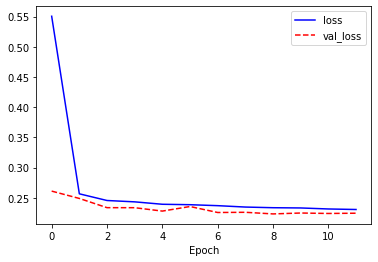

In [23]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0758 - val_loss: 0.0842
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0732 - val_loss: 0.0840
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0728 - val_loss: 0.0833
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0727 - val_loss: 0.0826
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0810
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0723 - val_loss: 0.0814
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0723 - val_loss: 0.0812
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0717 - val_loss: 0.0857
Epoch 00008: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 0.1022 - val_loss: 0.1173
Epoch 2/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 1s 1ms/step - loss: 0.1002 - val_loss: 0.1101
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0986 - val_loss: 0.1115
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0991 - val_loss: 0.1127
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0986 - val_loss: 0.1121
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0869 - val_loss: 0.0969
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0854 - val_loss: 0.0966
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0861 - val_loss: 0.0950
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0854 - val_loss: 0.0966
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0858 - val_loss: 0.0977
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 

820/820 [==============================] - 1s 1ms/step - loss: 0.0276 - val_loss: 0.0309
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0307
Epoch 00004: early stopping


(3888, 18)

In [27]:
from lightgbm import LGBMRegressor

In [28]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.0684705
Early stopping, best iteration is:
[513]	valid_0's quantile: 0.0684521
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.096005
[1000]	valid_0's quantile: 0.0956216
[1500]	valid_0's quantile: 0.0954233
Early stopping, best iteration is:
[1431]	valid_0's quantile: 0.0953849
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.106008
[1000]	valid_0's quantile: 0.105054
[1500]	valid_0's quantile: 0.104697
[2000]	valid_0's quantile: 0.104418
[2500]	valid_0's quantile: 0.104282
[3000]	valid_0's quantile: 0.104184
[3500]	valid_0's quantile: 0.104135
[4000]	valid_0's quantile: 0.104022
[4500]	valid_0's quantile: 0.10394
Early stopping, best iteration is:
[4657]	valid_0's quantile: 0.103933
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 0.105027
[1000]	valid_0's qua

In [29]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0850 - val_loss: 0.0860
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0749 - val_loss: 0.0846
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0741 - val_loss: 0.0845
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0738 - val_loss: 0.0848
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0723 - val_loss: 0.0840
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0730 - val_loss: 0.0834
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0727 - val_loss: 0.0832
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0731 - val_loss: 0.0843
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0719 - val_loss: 0.0826
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0723 - va

820/820 [==============================] - 2s 2ms/step - loss: 0.0269 - val_loss: 0.0308
Epoch 00006: early stopping


(3888, 9)

In [30]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0877 - val_loss: 0.0894
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0788 - val_loss: 0.0872
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0770 - val_loss: 0.0875
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0769 - val_loss: 0.0878
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0777 - val_loss: 0.0854
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0865
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0770 - val_loss: 0.0854
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.0900
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0860
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0766 - va

820/820 [==============================] - 1s 2ms/step - loss: 0.0889 - val_loss: 0.0989
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0872 - val_loss: 0.0983
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0890 - val_loss: 0.0974
Epoch 00007: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0713 - val_loss: 0.0792
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0706 - val_loss: 0.0772
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0705 - val_loss: 0.0790
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0706 - val_loss: 0.0787
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0713 - val_loss: 0.0791
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0701 - val_loss: 0.0771
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - lo

(3888, 9)

In [31]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 5s 4ms/step - loss: 1.0586 - val_loss: 0.2877
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2866 - val_loss: 0.2751
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2763 - val_loss: 0.2650
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2678 - val_loss: 0.2582
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2612 - val_loss: 0.2503
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2496 - val_loss: 0.2450
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2519 - val_loss: 0.2440
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2324 - val_loss: 0.2380
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2459 - val_loss: 0.2362
Epoch 10/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2388 - val_lo

In [32]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.0907 - val_loss: 0.0874
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0763 - val_loss: 0.0866
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0763 - val_loss: 0.0855
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0758 - val_loss: 0.0852
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0740 - val_loss: 0.0843
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0750 - val_loss: 0.0853
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0744 - val_loss: 0.0842
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0749 - val_loss: 0.0836
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0737 - val_loss: 0.0843
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0748 - va

820/820 [==============================] - 5s 4ms/step - loss: 0.1118 - val_loss: 0.1239
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1090 - val_loss: 0.1238
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.1105 - val_loss: 0.1229
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.1091 - val_loss: 0.1240
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1097 - val_loss: 0.1249
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1106 - val_loss: 0.1253
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1106 - val_loss: 0.1230
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1107 - val_loss: 0.1238
Epoch 00008: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.1047 - val_loss: 0.1158
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - lo

820/820 [==============================] - 2s 3ms/step - loss: 0.0845 - val_loss: 0.0950
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0852 - val_loss: 0.0969
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0844 - val_loss: 0.0949
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0843 - val_loss: 0.0992
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0856 - val_loss: 0.0960
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0856 - val_loss: 0.0950
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0855 - val_loss: 0.0943
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0842 - val_loss: 0.0939
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0855 - val_loss: 0.0951
Epoch 11/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0830 - val_loss: 0.0941


820/820 [==============================] - 5s 4ms/step - loss: 0.0275 - val_loss: 0.0300
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0266 - val_loss: 0.0296
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0270 - val_loss: 0.0306
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0268 - val_loss: 0.0302
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0267 - val_loss: 0.0298
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0271 - val_loss: 0.0298
Epoch 00007: early stopping


(3888, 9)

In [33]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0902 - val_loss: 0.0877
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0765 - val_loss: 0.0869
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0765 - val_loss: 0.0858
Epoch 4/100
820/820 [==============================] - 4s 4ms/step - loss: 0.0763 - val_loss: 0.0865
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0744 - val_loss: 0.0851
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0754 - val_loss: 0.0856
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0746 - val_loss: 0.0844
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0751 - val_loss: 0.0839
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0739 - val_loss: 0.0836
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0748 - va

820/820 [==============================] - 2s 3ms/step - loss: 0.1109 - val_loss: 0.1242
Epoch 11/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1074 - val_loss: 0.1257
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 0.1088 - val_loss: 0.1246
Epoch 13/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1082 - val_loss: 0.1253
Epoch 14/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1098 - val_loss: 0.1243
Epoch 00014: early stopping
0.4
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.1111 - val_loss: 0.1231
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1086 - val_loss: 0.1233
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1099 - val_loss: 0.1229
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1084 - val_loss: 0.1229
Epoch 5/100
820/820 [==============================] - 2s 3ms/step 

820/820 [==============================] - 2s 3ms/step - loss: 0.0852 - val_loss: 0.0972
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0863 - val_loss: 0.0949
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0863 - val_loss: 0.0951
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0862 - val_loss: 0.0942
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0845 - val_loss: 0.0945
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0861 - val_loss: 0.0952
Epoch 11/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0835 - val_loss: 0.0948
Epoch 12/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0842 - val_loss: 0.0951
Epoch 13/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0838 - val_loss: 0.0945
Epoch 00013: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 5s 4ms/step 

(3888, 9)

In [34]:
model = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 5s 4ms/step - loss: 1.5242 - val_loss: 0.3013
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2948 - val_loss: 0.2863
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2836 - val_loss: 0.2721
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2749 - val_loss: 0.2640
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2667 - val_loss: 0.2563
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2546 - val_loss: 0.2486
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2546 - val_loss: 0.2445
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2338 - val_loss: 0.2399
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2459 - val_loss: 0.2354
Epoch 10/100
615/615 [==============================] - 2s 3ms/step - loss: 0.2377 - val_lo

In [35]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.0950 - val_loss: 0.0874
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0761 - val_loss: 0.0868
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0764 - val_loss: 0.0858
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0760 - val_loss: 0.0858
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0743 - val_loss: 0.0848
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0750 - val_loss: 0.0855
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0743 - val_loss: 0.0845
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0746 - val_loss: 0.0836
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0735 - val_loss: 0.0832
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0743 - va

820/820 [==============================] - 5s 4ms/step - loss: 0.1115 - val_loss: 0.1236
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1087 - val_loss: 0.1242
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1102 - val_loss: 0.1229
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1088 - val_loss: 0.1238
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1093 - val_loss: 0.1246
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.1103 - val_loss: 0.1246
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.1046 - val_loss: 0.1158
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1022 - val_loss: 0.1159
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1030 - val_loss: 0.1155
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - lo

Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0712 - val_loss: 0.0788
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0719 - val_loss: 0.0794
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0709 - val_loss: 0.0816
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0713 - val_loss: 0.0804
Epoch 00005: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.0533 - val_loss: 0.0576
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0516 - val_loss: 0.0565
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0518 - val_loss: 0.0572
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0513 - val_loss: 0.0562
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0514 - val_loss: 0.0577
Epoch 6/100
820/820 [==============================] - 2s 3

(3888, 9)

In [36]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0950 - val_loss: 0.0873
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0760 - val_loss: 0.0865
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0762 - val_loss: 0.0858
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0758 - val_loss: 0.0854
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0741 - val_loss: 0.0845
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0749 - val_loss: 0.0860
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0745 - val_loss: 0.0849
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0747 - val_loss: 0.0837
Epoch 9/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0736 - val_loss: 0.0833
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0745 - va

Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1108 - val_loss: 0.1240
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1093 - val_loss: 0.1245
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1100 - val_loss: 0.1245
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 0.1109 - val_loss: 0.1255
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.1052 - val_loss: 0.1169
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.1026 - val_loss: 0.1166
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.1033 - val_loss: 0.1168
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.1023 - val_loss: 0.1161
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.1027 - val_loss: 0.1152
Epoch 6/100
820/820 [==============================] - 3s 4

0.8
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0532 - val_loss: 0.0572
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0516 - val_loss: 0.0570
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0520 - val_loss: 0.0569
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0514 - val_loss: 0.0565
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0513 - val_loss: 0.0574
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0522 - val_loss: 0.0561
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0520 - val_loss: 0.0566
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0516 - val_loss: 0.0570
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0510 - val_loss: 0.0569
Epoch 00009: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 

In [37]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [38]:
res_0 = pd.DataFrame()
res_0res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [39]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [40]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [42]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
for col in ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']:
    submission[col] = np.expm1(submission[col])

In [51]:
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
submission.to_csv('./submission/submission_20210122-1.csv', index=False)